In [12]:
# run using kernel wwa_prep
import xarray as xr, cartopy, numpy as np, pandas as pd
from xclim.indices import uas_vas_to_sfcwind

import pycircular
import scipy.stats

import matplotlib.pyplot as plt

import glob, re
# from math import atan, atan2

mapproj = cartopy.crs.PlateCarree()

Xn,Xx,Yn,Yx = [19,38,33,46]        # show full study region
xn,xx,yn,yx = [23.5,28.5,35,41]    # from https://journals.ametsoc.org/view/journals/atsc/70/11/jas-d-13-035.1.xml

# Get u,v components from ERA5

In [ ]:
# ! wget https://object-store.os-api.cci2.ecmwf.int/cci2-prod-cache-2/2025-08-13/80aad9353c603736fc7a90cba6943d0f.grib -O data/uv_era5_2000-2025.grib
# ! wget https://object-store.os-api.cci2.ecmwf.int/cci2-prod-cache-2/2025-08-13/f629b208310f0fec79f36a32e4bc33c0.grib -O data/uv_era5_1980-1999.grib
# ! wget https://object-store.os-api.cci2.ecmwf.int/cci2-prod-cache-1/2025-08-13/90400f2f7172cf1f505a5ce52a113756.grib -O data/uv_era5_1960-1979.grib
# ! wget https://object-store.os-api.cci2.ecmwf.int/cci2-prod-cache-3/2025-08-13/dfa9b7bc2788c806910251597cebb8f4.grib -O data/uv_era5_1940-1959.grib

In [ ]:
# # convert grib to netcdf
# da_list = [xr.open_dataset(fnm, engine = "cfgrib").reset_coords(drop = True) for fnm in glob.glob("data/*.grib")]
# da = xr.concat(da_list, "time")
# da = da.sortby(da.time)
# da.to_netcdf("data/uv-hourly_era5_"+str(da.time.min().dt.strftime("%Y%m%d").values)+"-"+str(da.time.max().dt.strftime("%Y%m%d").values)+".nc")

# Compute wind direction & speed

In [160]:
fnm = sorted(glob.glob("data/uv-hourly_*.nc"))[-1]

da = xr.open_dataset(fnm)
sfcWind, wind_from_dir = uas_vas_2_sfcwind(da.u10, da.v10)

sfcWind.rename("sfcWind").to_netcdf(re.sub("uv", "sfcWind", fnm))

wind_from_dir = np.deg2rad(wind_from_dir).assign_attrs(units = "radian")
wind_from_dir.rename("windfrom").to_netcdf(re.sub("uv", "windfrom", fnm))

In [161]:
cmean = xr.apply_ufunc(scipy.stats.circmean, wind_from_dir, input_core_dims = [["latitude","longitude"]], vectorize = True)
cstd = xr.apply_ufunc(scipy.stats.circstd, wind_from_dir, input_core_dims = [["latitude","longitude"]], vectorize = True)

In [163]:
xr.merge([cmean.rename("windfrom_mean"), cstd.rename("windfrom_sd")]).to_netcdf(re.sub("uv", "mean-wind-dir", fnm))

# Some plots

In [2]:
ds = xr.open_dataset("data/mean-wind-dir-hourly_era5_19400701-20250808.nc")

In [3]:
ds_d = ds.resample(time = "D").mean()

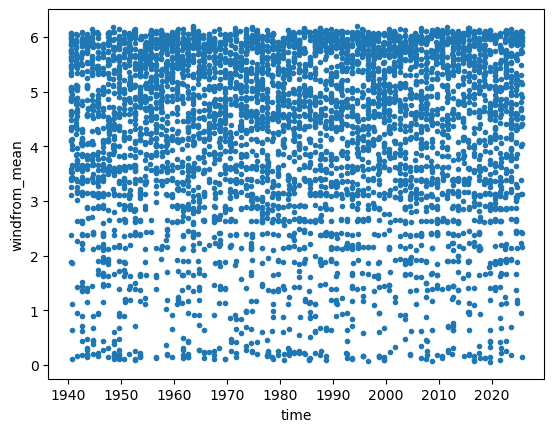

In [7]:
ds_d.windfrom_mean.plot(marker = ".", ls = "")

# Pycircular plot

In [ ]:
wind_from = ds_d.to_dataframe()

In [119]:
wind_from.to_csv("wind-direction_ja_era5.csv")

In [112]:
# bin wind speeds
nbins = 20

binned = pd.cut(wind_from.windfrom, np.arange(0, 2*np.pi+(np.pi/(nbins/2)), np.pi/(nbins/2)))
counts = wind_from.groupby(binned, observed = False).count()
midpoints = np.array([(a.left + a.right)/2 for a in counts.index])

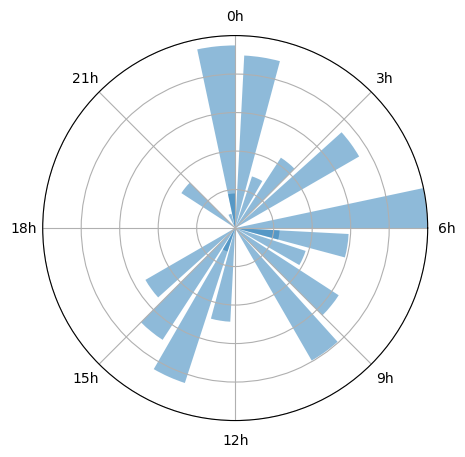

In [114]:
fig, ax1 = pycircular.plots.base_periodic_fig(counts.windfrom, midpoints, figsize = (5,5))

In [115]:
pycircular.plots.base_periodic_fig

<function pycircular.plots.base_periodic_fig(dates, freq, bottom=0, ymax=1, rescale=True, figsize=(8, 8), time_segment='hour', fig=None, ax1=None)>

In [70]:
for i in range(y_test.shape[0]):
    ax1.bar([radians[i]], [1], width=0.05, label=y_test.loc[i, 'dates'])

['__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 '_date2rad',
 'date2rad',
 'freq_time',
 'np',
 'pd']

In [64]:
pycircular.utils.freq_time(pd.to_datetime(wind_from.index), time_segment = "day", freq = True, continious = True)

UnboundLocalError: cannot access local variable 'time_temp' where it is not associated with a value

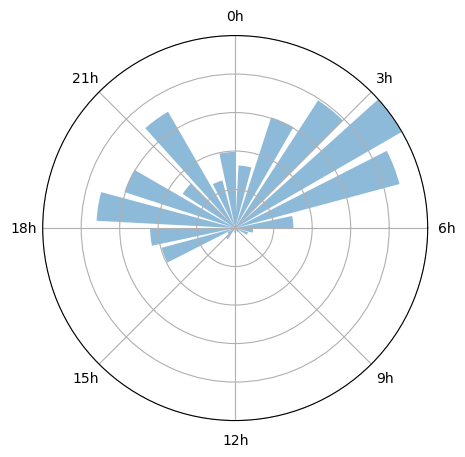

In [ ]:
fig, ax1 = pycircular.plots.base_periodic_fig(freq_arr[:, 0], freq_arr[:, 1], time_segment=time_segment, figsize = (5,5))

DatetimeIndex(['1940-07-01', '1940-07-02', '1940-07-03', '1940-07-04',
               '1940-07-05', '1940-07-06', '1940-07-07', '1940-07-08',
               '1940-07-09', '1940-07-10',
               ...
               '2025-07-30', '2025-07-31', '2025-08-01', '2025-08-02',
               '2025-08-03', '2025-08-04', '2025-08-05', '2025-08-06',
               '2025-08-07', '2025-08-08'],
              dtype='datetime64[ns]', name='time', length=31085, freq='D')

# Pycircular tutorial

In [ ]:
df = pycircular.datasets.load_transactions()['data']
df['date']= pd.to_datetime(df['date'])
dates = df.loc[df['user'] == 1, 'date']

,user,type,amt,date
1,1,1,-0.334,2020-01-01 03:09:57
5,2,1,-0.238,2020-01-01 04:01:43
6,1,1,-0.247,2020-01-01 16:37:52
9,1,2,0.537,2020-01-01 19:16:12
12,1,2,0.537,2020-01-01 19:16:58
...,...,...,...,...
102,2,2,-0.079,2020-07-25 20:41:20
103,2,1,-0.030,2020-07-25 22:37:33
104,1,1,-0.077,2020-07-27 02:34:13
107,2,2,0.541,2020-07-27 02:35:54


In [ ]:
freq_arr, times = pycircular.utils.freq_time(dates , time_segment=time_segment)

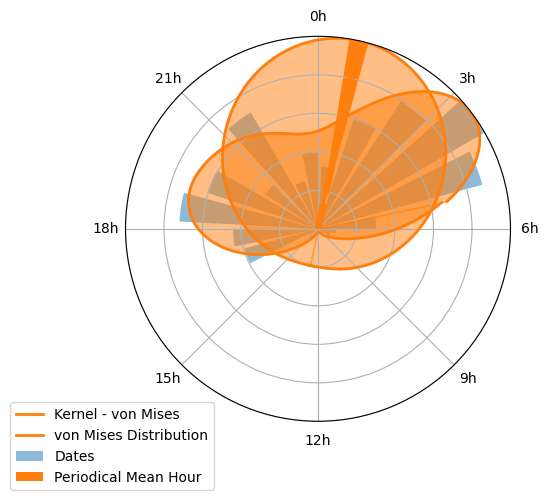

In [43]:
# convert times to degree
time_segment = 'hour'  # 'hour', 'dayweek', 'daymonth
freq_arr, times = pycircular.utils.freq_time(dates , time_segment=time_segment)

# circular plot with optional KDE
# fig, ax1 = pycircular.plots.base_periodic_fig(freq_arr[:, 0], freq_arr[:, 1], time_segment=time_segment, figsize = (5,5))
y = pycircular.circular.kernel(radians.values)
fig, ax1 = pycircular.plots.plot_kernel(freq_arr[:, 0], freq_arr[:, 1], y,time_segment=time_segment, figsize = (5,5))

# add circular mean
radians = pycircular.utils._date2rad(dates, time_segment='hour')
mean, std = pycircular.stats.periodic_mean_std(radians)
ax1.bar([mean], [1], width=0.1, label='Periodical Mean Hour')

# add the von Mises distribution (weird way to display it, but nvm)
x, p = pycircular.stats.von_mises_distribution(mean, std)
ax1 = pycircular.plots.clock_vonmises_distribution(ax1, mean, x, p)

# add legend
# ax1.legend(bbox_to_anchor=(-0.3, 0.05), loc="upper left", borderaxespad=0)